In [31]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [32]:
x_train = pd.read_csv('/content/drive/MyDrive/public_data/x_train.csv')
y_train = pd.read_csv('/content/drive/MyDrive/public_data/y_train.csv')
x_test = pd.read_csv('/content/drive/MyDrive/public_data/x_test.csv')

In [33]:
# we are going to do some EDA
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1494 entries, 0 to 1493
Data columns (total 35 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                1494 non-null   int64  
 1   DAY_ID            1494 non-null   int64  
 2   COUNTRY           1494 non-null   object 
 3   DE_CONSUMPTION    1494 non-null   float64
 4   FR_CONSUMPTION    1494 non-null   float64
 5   DE_FR_EXCHANGE    1469 non-null   float64
 6   FR_DE_EXCHANGE    1469 non-null   float64
 7   DE_NET_EXPORT     1370 non-null   float64
 8   FR_NET_EXPORT     1424 non-null   float64
 9   DE_NET_IMPORT     1370 non-null   float64
 10  FR_NET_IMPORT     1424 non-null   float64
 11  DE_GAS            1494 non-null   float64
 12  FR_GAS            1494 non-null   float64
 13  DE_COAL           1494 non-null   float64
 14  FR_COAL           1494 non-null   float64
 15  DE_HYDRO          1494 non-null   float64
 16  FR_HYDRO          1494 non-null   float64


In [34]:
# we can see from above there are null entries in the dataset.
NA_columns = []
for column in x_train:
  count = x_train[column].isna().sum()
  if count > 0:
    NA_columns.append(column)
  print(f"There are {count} NA entries in column {column}")

There are 0 NA entries in column ID
There are 0 NA entries in column DAY_ID
There are 0 NA entries in column COUNTRY
There are 0 NA entries in column DE_CONSUMPTION
There are 0 NA entries in column FR_CONSUMPTION
There are 25 NA entries in column DE_FR_EXCHANGE
There are 25 NA entries in column FR_DE_EXCHANGE
There are 124 NA entries in column DE_NET_EXPORT
There are 70 NA entries in column FR_NET_EXPORT
There are 124 NA entries in column DE_NET_IMPORT
There are 70 NA entries in column FR_NET_IMPORT
There are 0 NA entries in column DE_GAS
There are 0 NA entries in column FR_GAS
There are 0 NA entries in column DE_COAL
There are 0 NA entries in column FR_COAL
There are 0 NA entries in column DE_HYDRO
There are 0 NA entries in column FR_HYDRO
There are 0 NA entries in column DE_NUCLEAR
There are 0 NA entries in column FR_NUCLEAR
There are 0 NA entries in column DE_SOLAR
There are 0 NA entries in column FR_SOLAR
There are 0 NA entries in column DE_WINDPOW
There are 0 NA entries in column 

In [35]:
# replace NA entries with the mean
for col in NA_columns:
  x_train[col].fillna(x_train[col].mean(), inplace=True)

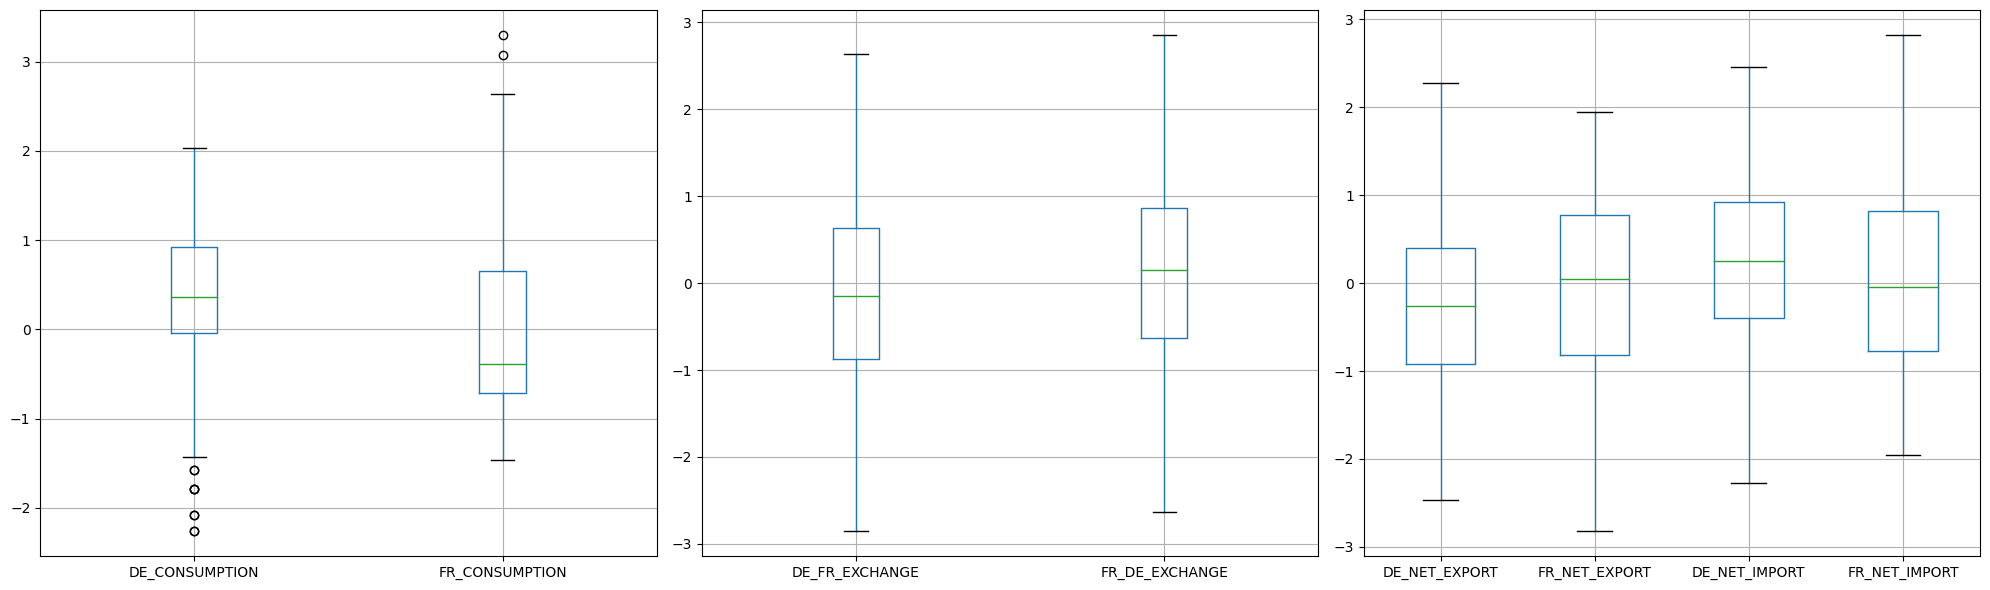

In [36]:
# creating boxplots for commercial data
cols = x_train.columns.tolist()
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

boxplot_consumption = x_train.boxplot(column = cols[3:5], ax=axs.flatten()[0])
boxplot_trades = x_train.boxplot(column = cols[5:7], ax=axs.flatten()[1])
boxplot_importexport = x_train.boxplot(column = cols[7:11], ax=axs.flatten()[2])

plt.tight_layout()
plt.show()

# from the plot we can see that the exchange boxplots,
# import-export boxplots for each country seem inverted - makes sense !
# need to explore this further
# maybe we don't need both import and export, and both exchanges

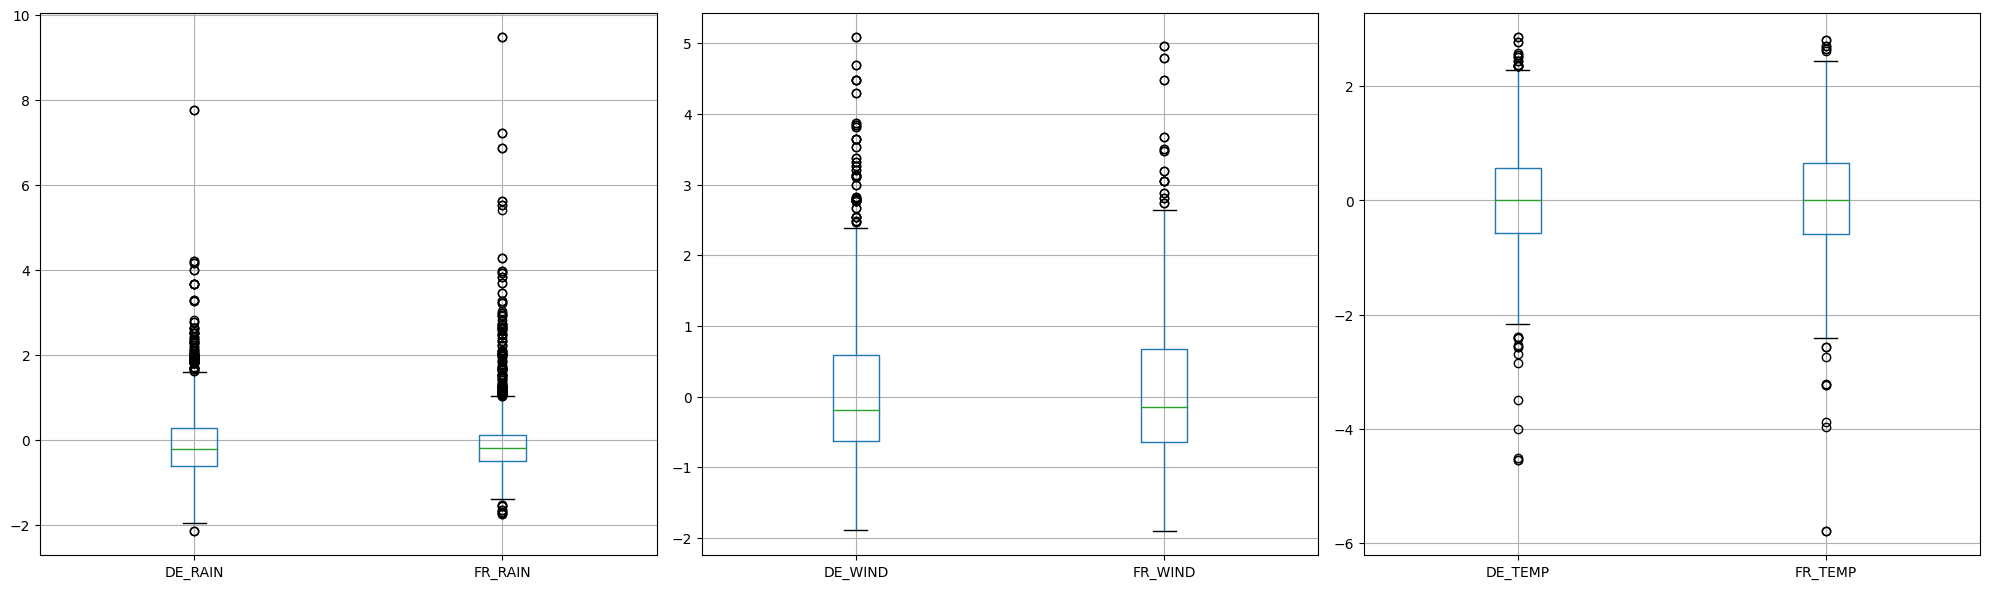

In [37]:
# creating boxplots for weather data
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

boxplot_rain = x_train.boxplot(column = cols[26:28], ax=axs.flatten()[0])
boxplot_trades = x_train.boxplot(column = cols[28:30], ax=axs.flatten()[1])
boxplot_importexport = x_train.boxplot(column = cols[30:32], ax=axs.flatten()[2])

plt.tight_layout()
plt.show()

# very variable - lots of outliers, especially rain !

<Axes: >

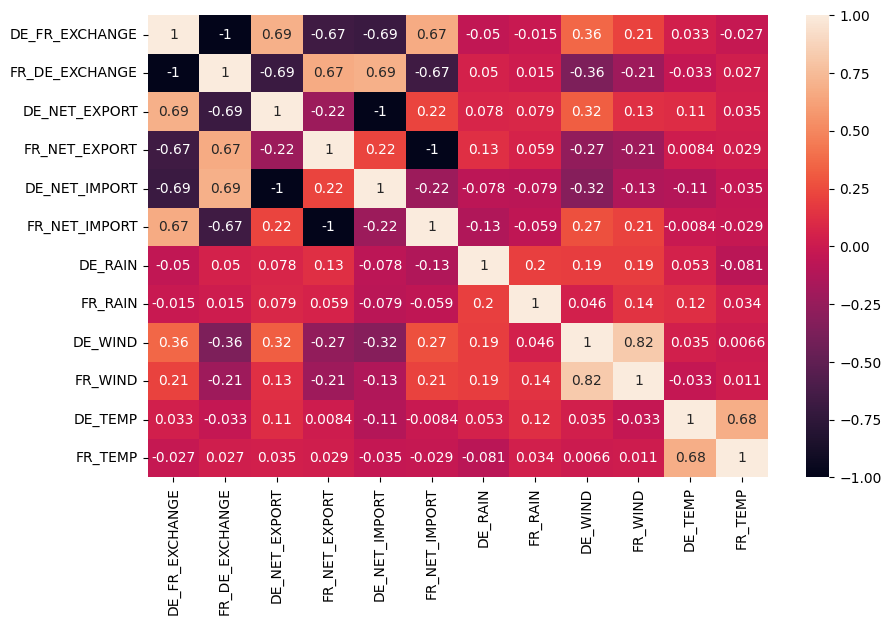

In [38]:
# create correlation matrix to explore the boxplot inversion further

cor = x_train[NA_columns].corr()
plt.figure(figsize = (10,6))
sns.heatmap(cor, annot=True)

# we can clearly see that the exchanges, and the import-exports in each country
# have a perfect negative correlation as hypothesised
# so we might not need to include all these variables in our model

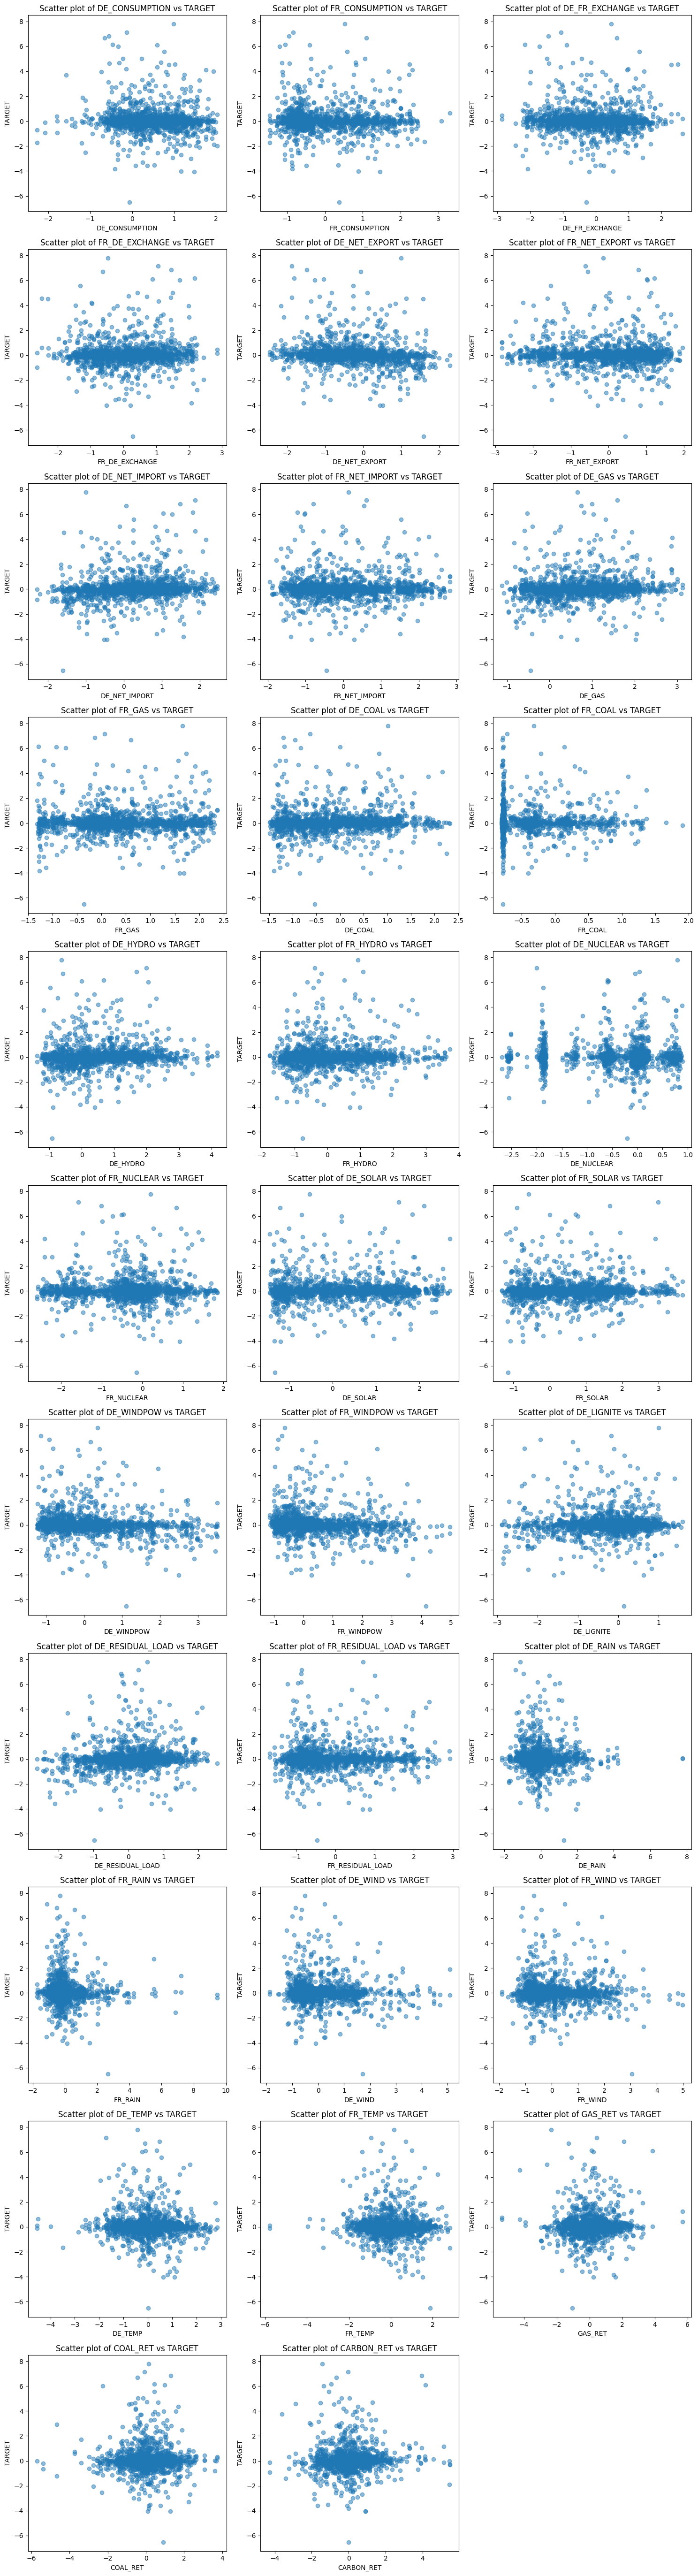

In [39]:
# Selecting the columns to plot (starting from 'DE_CONSUMPTION')
columns_to_plot = x_train.columns[x_train.columns.get_loc('DE_CONSUMPTION'):]

num_cols = 3
num_rows = len(columns_to_plot) // num_cols + (len(columns_to_plot) % num_cols > 0)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

axs = axs.flatten()

for i, column in enumerate(columns_to_plot):
    axs[i].scatter(x_train[column], y_train['TARGET'], alpha=0.5)
    axs[i].set_title(f"Scatter plot of {column} vs TARGET")
    axs[i].set_xlabel(column)
    axs[i].set_ylabel('TARGET')

# Hide any empty subplots
for i in range(len(columns_to_plot), num_rows * num_cols):
    fig.delaxes(axs[i])

# see the single relationship between each feature and target
plt.tight_layout()
plt.show()
# fr_coal and de_nucelar are interesting

In [40]:
# let's do some feature importance
# first we will see which energy products have the biggest correlation with exports

germany_columns = ['DE_NET_EXPORT', 'DE_GAS', 'DE_COAL', 'DE_HYDRO', 'DE_NUCLEAR', 'DE_SOLAR', 'DE_WINDPOW', 'DE_LIGNITE']
france_columns = ['FR_NET_EXPORT', 'FR_GAS', 'FR_COAL', 'FR_HYDRO', 'FR_NUCLEAR', 'FR_SOLAR', 'FR_WINDPOW']


germany_export = x_train[germany_columns].corr().loc['DE_NET_EXPORT'].drop('DE_NET_EXPORT')

france_export = x_train[france_columns].corr().loc['FR_NET_EXPORT'].drop('FR_NET_EXPORT')

# now we do the same for consumptions
germany_consumption_columns = ['DE_CONSUMPTION', 'DE_GAS', 'DE_COAL', 'DE_HYDRO', 'DE_NUCLEAR', 'DE_SOLAR', 'DE_WINDPOW', 'DE_LIGNITE']
france_consumption_columns = ['FR_CONSUMPTION', 'FR_GAS', 'FR_COAL', 'FR_HYDRO', 'FR_NUCLEAR', 'FR_SOLAR', 'FR_WINDPOW']


germany_consumption = x_train[germany_consumption_columns].corr().loc['DE_CONSUMPTION'].drop('DE_CONSUMPTION')


france_consumption = x_train[france_consumption_columns].corr().loc['FR_CONSUMPTION'].drop('FR_CONSUMPTION')

print("Germany Main Exports:")
print(germany_export)

print("Germany Main Consumptions:")
print(germany_consumption)

print("France Main Exports:")
print(france_export)

print("France Main Consumptions:")
print(france_consumption)

Germany Main Exports:
DE_GAS       -0.204136
DE_COAL       0.155730
DE_HYDRO     -0.430015
DE_NUCLEAR    0.157505
DE_SOLAR     -0.454906
DE_WINDPOW    0.740662
DE_LIGNITE    0.063540
Name: DE_NET_EXPORT, dtype: float64
Germany Main Consumptions:
DE_GAS        0.233345
DE_COAL       0.455872
DE_HYDRO     -0.365692
DE_NUCLEAR    0.240710
DE_SOLAR     -0.640844
DE_WINDPOW    0.475986
DE_LIGNITE    0.345409
Name: DE_CONSUMPTION, dtype: float64
France Main Exports:
FR_GAS       -0.453208
FR_COAL      -0.243794
FR_HYDRO      0.107752
FR_NUCLEAR    0.435130
FR_SOLAR     -0.114951
FR_WINDPOW    0.139986
Name: FR_NET_EXPORT, dtype: float64
France Main Consumptions:
FR_GAS        0.779727
FR_COAL       0.580789
FR_HYDRO      0.619409
FR_NUCLEAR    0.705734
FR_SOLAR     -0.653394
FR_WINDPOW    0.330130
Name: FR_CONSUMPTION, dtype: float64


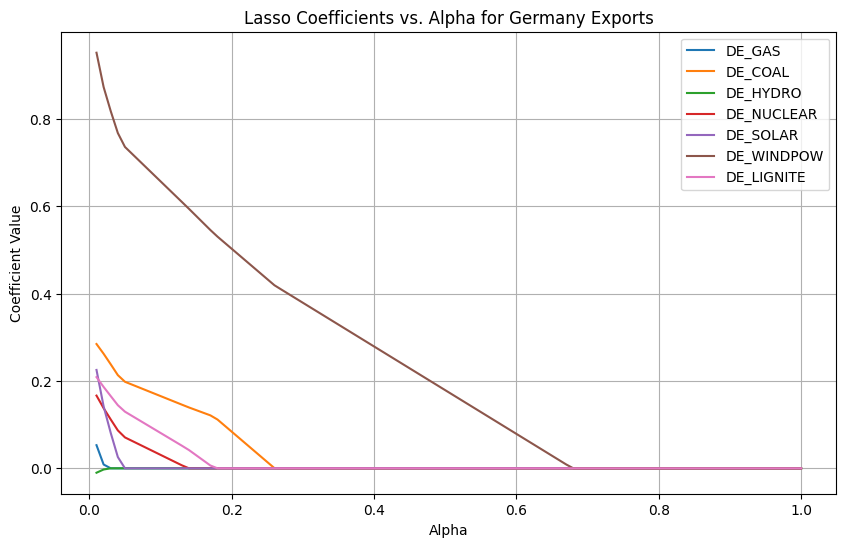

In [41]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

germany_export_features = x_train[germany_columns]
X_germany_export = germany_export_features.drop('DE_NET_EXPORT', axis=1)
y_germany_export = germany_export_features['DE_NET_EXPORT']

# Scaling the features
scaler = StandardScaler()
X_germany_export_scaled = scaler.fit_transform(X_germany_export)

# Initialize arrays to store coefficients for each alpha
alphas = np.linspace(0.01, 1, 100)  # Defining a range of alpha values
coefficients = []

# Iteratively fit the Lasso model for different alpha values
for alpha in alphas:
    lasso_germany_export = Lasso(alpha=alpha)
    lasso_germany_export.fit(X_germany_export_scaled, y_germany_export)
    coefficients.append(lasso_germany_export.coef_)

# Plotting the coefficient changes with alpha
coefficients = np.array(coefficients).T  # Transpose for easier plotting

plt.figure(figsize=(10, 6))
for i in range(len(X_germany_export.columns)):
    plt.plot(alphas, coefficients[i], label=X_germany_export.columns[i])

plt.title('Lasso Coefficients vs. Alpha for Germany Exports')
plt.xlabel('Alpha')
plt.ylabel('Coefficient Value')
plt.legend()
plt.grid(True)
plt.show()

# windpower & coal are a big german export

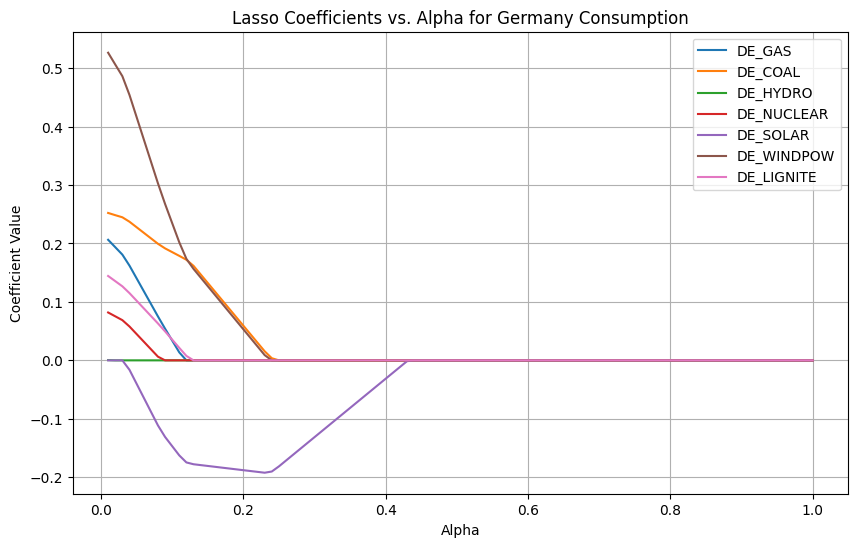

In [42]:
germany_cons_features = x_train[germany_consumption_columns]
X_germany_cons = germany_cons_features.drop('DE_CONSUMPTION', axis=1)
y_germany_cons = germany_cons_features['DE_CONSUMPTION']

scaler = StandardScaler()
X_germany_cons_scaled = scaler.fit_transform(X_germany_cons)
alphas = np.linspace(0.01, 1, 100)
coefficients = []

for alpha in alphas:
    lasso_germany_cons = Lasso(alpha=alpha)
    lasso_germany_cons.fit(X_germany_cons_scaled, y_germany_cons)
    coefficients.append(lasso_germany_cons.coef_)

coefficients = np.array(coefficients).T

plt.figure(figsize=(10, 6))
for i in range(len(X_germany_cons.columns)):
    plt.plot(alphas, coefficients[i], label=X_germany_cons.columns[i])

plt.title('Lasso Coefficients vs. Alpha for Germany Consumption')
plt.xlabel('Alpha')
plt.ylabel('Coefficient Value')
plt.legend()
plt.grid(True)
plt.show()

# wind power & coal (maybe solar) production have a big impact on german consumption

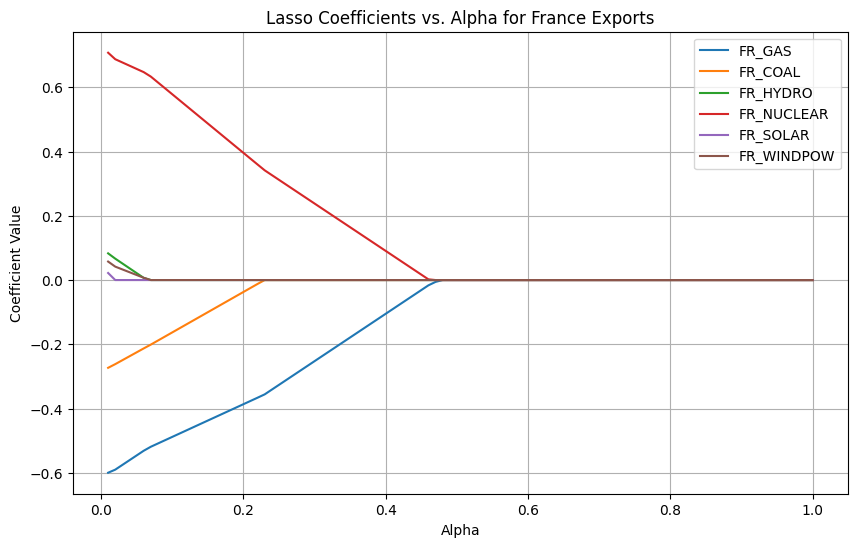

In [43]:

france_export_features = x_train[france_columns]
X_france_export = france_export_features.drop('FR_NET_EXPORT', axis=1)
y_france_export = france_export_features['FR_NET_EXPORT']

scaler = StandardScaler()
X_france_export_scaled = scaler.fit_transform(X_france_export)

alphas = np.linspace(0.01, 1, 100)
coefficients = []

for alpha in alphas:
    lasso_france_export = Lasso(alpha=alpha)
    lasso_france_export.fit(X_france_export_scaled, y_france_export)
    coefficients.append(lasso_france_export.coef_)

coefficients = np.array(coefficients).T

plt.figure(figsize=(10, 6))
for i in range(len(X_france_export.columns)):
    plt.plot(alphas, coefficients[i], label=X_france_export.columns[i])

plt.title('Lasso Coefficients vs. Alpha for France Exports')
plt.xlabel('Alpha')
plt.ylabel('Coefficient Value')
plt.legend()
plt.grid(True)
plt.show()
# nuclear & gas have a big impact on french exports

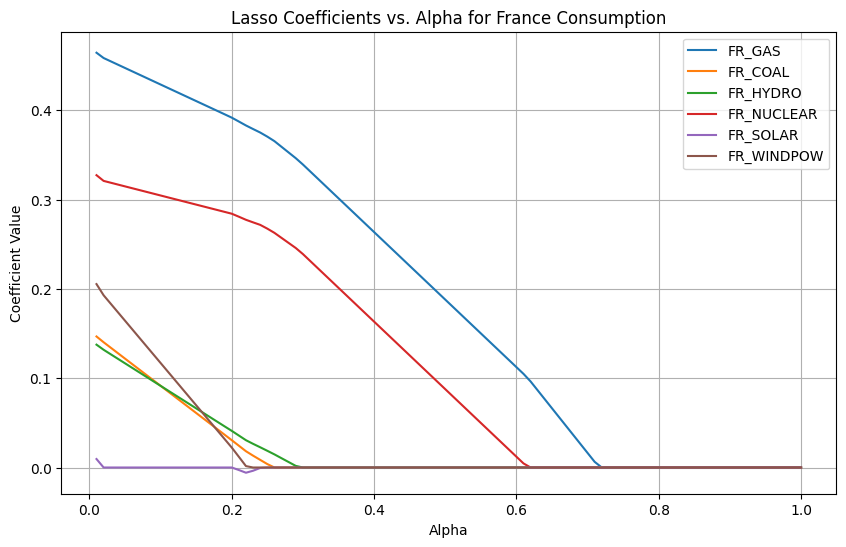

In [44]:
# Extracting features and the target for France's consumption
france_cons_features = x_train[france_consumption_columns]
X_france_cons = france_cons_features.drop('FR_CONSUMPTION', axis=1)
y_france_cons = france_cons_features['FR_CONSUMPTION']

scaler = StandardScaler()
X_france_cons_scaled = scaler.fit_transform(X_france_cons)

alphas = np.linspace(0.01, 1, 100)
coefficients = []

for alpha in alphas:
    lasso_france_cons = Lasso(alpha=alpha)
    lasso_france_cons.fit(X_france_cons_scaled, y_france_cons)
    coefficients.append(lasso_france_cons.coef_)

coefficients = np.array(coefficients).T

plt.figure(figsize=(10, 6))
for i in range(len(X_france_cons.columns)):
    plt.plot(alphas, coefficients[i], label=X_france_cons.columns[i])

plt.title('Lasso Coefficients vs. Alpha for France Consumption')
plt.xlabel('Alpha')
plt.ylabel('Coefficient Value')
plt.legend()
plt.grid(True)
plt.show()
# nuclear & gas production have a big impact on french consumption

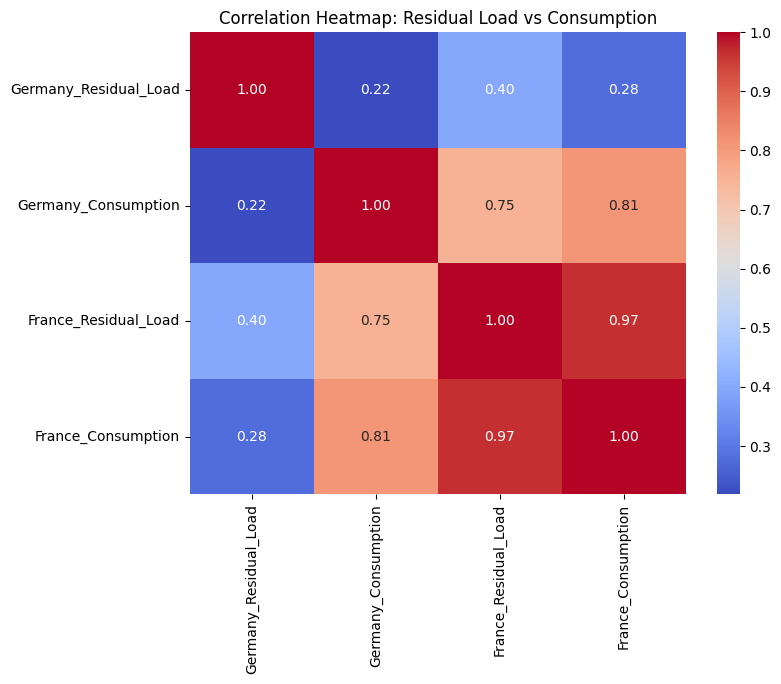

In [45]:
# From all this exploration it might be sensible to have strong weights for:
# DE: COAL & WINDPOW
# FR: GAS & NUCLEAR
# Let's look at x_RESIDUAL_LOAD and how it is related x_CONSUMPTION

germany_residual_load = x_train['DE_RESIDUAL_LOAD']
germany_consumption = x_train['DE_CONSUMPTION']

france_residual_load = x_train['FR_RESIDUAL_LOAD']
france_consumption = x_train['FR_CONSUMPTION']

cons_data = {
    'Germany_Residual_Load': germany_residual_load,
    'Germany_Consumption': germany_consumption,
    'France_Residual_Load': france_residual_load,
    'France_Consumption': france_consumption
}
cons_df = pd.DataFrame(cons_data)

correlation_matrix = cons_df.corr()

plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap: Residual Load vs Consumption')
plt.show()

# we have some evidence that germany rely on sustainable energy
# while france don't rely much on sustainable sources
# this means that weather data may have less of an impact for france
# all of this has to be taken into account in the model

In [46]:
# Now we will see how the conusmption, exports, residual and target are correlated
# for each country

columns_DE = ['DE_CONSUMPTION', 'DE_NET_EXPORT', 'DE_RESIDUAL_LOAD']
columns_FR = ['FR_CONSUMPTION', 'FR_NET_EXPORT', 'FR_RESIDUAL_LOAD']

data_DE = x_train[x_train['COUNTRY'] == 'DE'][columns_DE]
data_FR = x_train[x_train['COUNTRY'] == 'FR'][columns_FR]

data_DE['TARGET'] = y_train[x_train['COUNTRY'] == 'DE']['TARGET']
data_FR['TARGET'] = y_train[x_train['COUNTRY'] == 'FR']['TARGET']

correlation_matrix_DE = data_DE.corr()

correlation_matrix_FR = data_FR.corr()

print("Correlation Matrix for Germany:")
print(correlation_matrix_DE)

print("\nCorrelation Matrix for France:")
print(correlation_matrix_FR)

# not much correlation except that when DE imports more the price goes up?
# also potentially when DE has more residual load price goes up

Correlation Matrix for Germany:
                  DE_CONSUMPTION  DE_NET_EXPORT  DE_RESIDUAL_LOAD    TARGET
DE_CONSUMPTION          1.000000       0.521918          0.189010 -0.051182
DE_NET_EXPORT           0.521918       1.000000         -0.448005 -0.250616
DE_RESIDUAL_LOAD        0.189010      -0.448005          1.000000  0.250898
TARGET                 -0.051182      -0.250616          0.250898  1.000000

Correlation Matrix for France:
                  FR_CONSUMPTION  FR_NET_EXPORT  FR_RESIDUAL_LOAD    TARGET
FR_CONSUMPTION          1.000000      -0.212904          0.967214  0.009998
FR_NET_EXPORT          -0.212904       1.000000         -0.233452 -0.043032
FR_RESIDUAL_LOAD        0.967214      -0.233452          1.000000  0.038176
TARGET                  0.009998      -0.043032          0.038176  1.000000


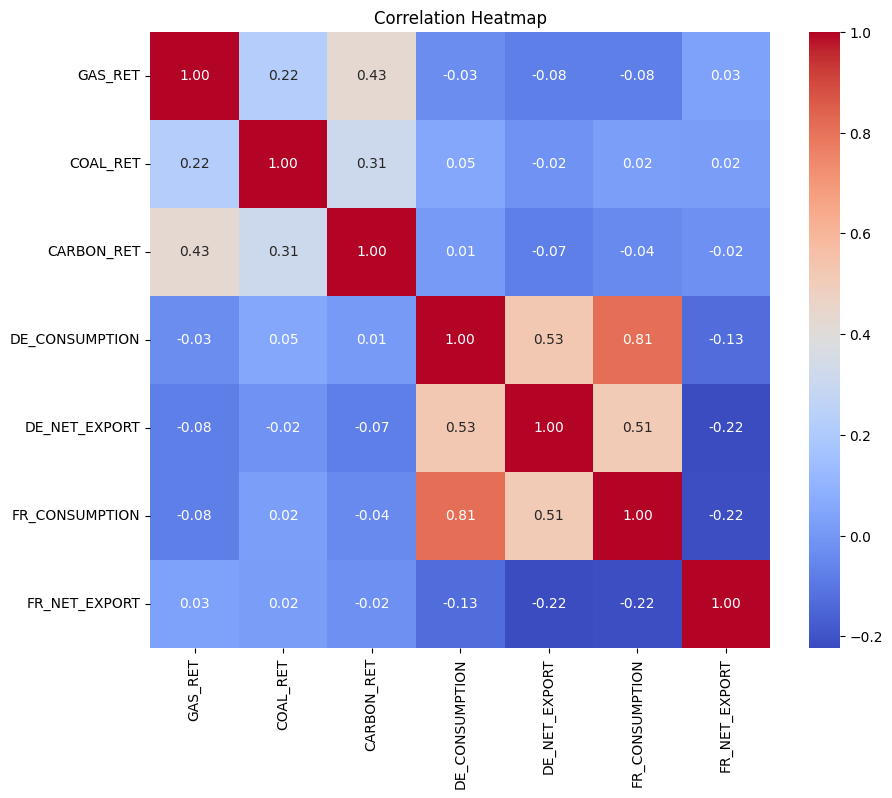

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1494 entries, 0 to 1493
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      1494 non-null   int64  
 1   TARGET  1494 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 23.5 KB


In [47]:
columns_of_interest = ['GAS_RET', 'COAL_RET', 'CARBON_RET', 'DE_CONSUMPTION', 'DE_NET_EXPORT', 'FR_CONSUMPTION', 'FR_NET_EXPORT']
data_of_interest = x_train[columns_of_interest]

# Fill missing values in the data with the mean
data_of_interest_filled = data_of_interest.fillna(data_of_interest.mean())
correlation_matrix = data_of_interest_filled.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

# the commodity prices don't seem to affect consumption or exports for any country
# this may well be excluded entirely
y_train.info()

In [53]:
# let's start with a linear regression for germany
# idea: supply and demand
# windpower affects germany exports which affects prices
# wind and solar affect consumption which affects prices
# from intuition temperature and wind will have an effect on these productions

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Specify the columns for Germany as per the defined features
germany_columns = ['DE_WINDPOW', 'DE_COAL', 'DE_NET_EXPORT']
germany_interactions = ['FR_DE_EXCHANGE', 'FR_NUCLEAR',
                        'DE_CONSUMPTION', 'DE_RESIDUAL_LOAD']

germany_linear = x_train.loc[x_train['COUNTRY'] == 'DE', germany_columns]
germany_linear = germany_linear.fillna(germany_linear.mean())

germany_quad = x_train.loc[x_train['COUNTRY'] == 'DE', germany_interactions]
germany_quad = germany_quad.fillna(germany_quad.mean())

y_germany = y_train.loc[x_train['COUNTRY'] == 'DE', 'TARGET']

X_linear = germany_linear[germany_columns]

X_interaction = germany_quad[germany_interactions]
poly_specific = PolynomialFeatures(degree=1, interaction_only=True, include_bias=False)
X_specific_interactions = poly_specific.fit_transform(X_interaction)

X_germany = np.concatenate((X_linear, X_specific_interactions), axis=1)

# linear regression model for Germany
lm_de = LinearRegression()
lm_de.fit(X_germany, y_germany)
print(lm_de.coef_)

from sklearn.model_selection import KFold
from scipy.stats import spearmanr

# Create K-fold cross-validation
kf = KFold(n_splits=5, random_state=42, shuffle=True)

# Initialize lists to store scores
lm_mse_scores, lm_spearman_scores = [], []

for train_index, test_index in kf.split(X_germany):
    X_tr, X_te = X_germany[train_index], X_germany[test_index]
    y_tr, y_te = y_germany.iloc[train_index], y_germany.iloc[test_index]

    lm = LinearRegression()
    lm.fit(X_tr, y_tr)
    lm_mse = mean_squared_error(y_te, lm.predict(X_te))
    lm_spearman = spearmanr(lm.predict(X_te), y_te).correlation
    lm_mse_scores.append(lm_mse)
    lm_spearman_scores.append(100 * lm_spearman)

print("Linear Regression - MSE scores:", lm_mse_scores)
print("Linear Regression - Spearman scores:", lm_spearman_scores)

[ 0.08268352 -0.02982898 -0.41597678 -0.21521965  0.11259743 -0.09758335
  0.22028939]
                            OLS Regression Results                            
Dep. Variable:                 TARGET   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     10.20
Date:                Sun, 05 Nov 2023   Prob (F-statistic):           3.89e-12
Time:                        09:53:42   Log-Likelihood:                -907.17
No. Observations:                 643   AIC:                             1830.
Df Residuals:                     635   BIC:                             1866.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------

In [57]:
# create linear regression to find supply-demand ratio
# then create linear regression with this ratio and targer

german_supply = x_train.loc[x_train['COUNTRY'] == 'DE', 'DE_WINDPOW'].to_numpy() + x_train.loc[x_train['COUNTRY'] == 'DE', 'DE_COAL'].to_numpy() + x_train.loc[x_train['COUNTRY'] == 'DE', 'FR_DE_EXCHANGE'].to_numpy() * x_train.loc[x_train['COUNTRY'] == 'DE', 'FR_NUCLEAR'].to_numpy() - x_train.loc[x_train['COUNTRY'] == 'DE', 'DE_NET_EXPORT'].to_numpy()

german_demand = x_train.loc[x_train['COUNTRY'] == 'DE', 'DE_CONSUMPTION'].to_numpy() * x_train.loc[x_train['COUNTRY'] == 'DE', 'DE_RESIDUAL_LOAD'].to_numpy()

sdr_DE = german_demand / german_supply
y_germany = y_train.loc[x_train['COUNTRY'] == 'DE', 'TARGET'].to_numpy()

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Reshape the data
sdr_DE = sdr_DE.reshape(-1, 1)
y_germany = y_germany.reshape(-1, 1)

# Perform train-test split if required
X_tr, X_te, y_tr, y_te = train_test_split(sdr_DE, y_germany, test_size=0.2, random_state=42)

# Create and fit the linear regression model
lm_sdr = LinearRegression()
lm_sdr.fit(X_tr, y_tr)
sprcoef_DE = spearmanr(lm_sdr.predict(X_te), y_te).correlation

print(f"Spearman Coefficient Score: {100 * sprcoef_DE}")


Spearman Coefficient Score: -22.796288014311273


In [ ]:
# Specify the columns for France
france_columns = ['DE_FR_EXCHANGE','DE_WINDPOW', 'FR_NUCLEAR', 'FR_GAS']
france_data = x_train.loc[x_train['COUNTRY'] == 'FR', france_columns]

france_data = france_data.fillna(france_data.mean())

y_france = y_train.loc[x_train['COUNTRY'] == 'FR', 'TARGET']
X_france = france_data[france_columns]


# linear regression model for France
lm_fr = LinearRegression()
lm_fr.fit(X_france, y_france)
print(lm_fr.coef_)

# Create K-fold cross-validation
kf = KFold(n_splits=5, random_state=42, shuffle=True)

# Initialize lists to store scores
lm_mse_scores, lm_spearman_scores = [], []
#rf_mse_scores, rf_spearman_scores = [], []

for train_index, test_index in kf.split(X_france):
    X_tr, X_te = X_france.iloc[train_index], X_france.iloc[test_index]
    y_tr, y_te = y_france.iloc[train_index], y_france.iloc[test_index]

    # Linear Regression
    lm = LinearRegression()
    lm.fit(X_tr, y_tr)
    lm_mse = mean_squared_error(y_te, lm.predict(X_te))
    lm_spearman = spearmanr(lm.predict(X_te), y_te).correlation
    lm_mse_scores.append(lm_mse)
    lm_spearman_scores.append(100 * lm_spearman)

print("Linear Regression - MSE scores:", lm_mse_scores)
print("Linear Regression - Spearman scores:", lm_spearman_scores)

[ 0.10263656 -0.11186856  0.04235903 -0.04351303]
Linear Regression - MSE scores: [1.4242346173901004, 0.6070231592825991, 0.7323402213562709, 1.0290125246351185, 1.439632588882641]
Linear Regression - Spearman scores: [4.6912452847857375, 6.394318549593615, 2.3362094760046657, 3.347441300091183, 12.916636388786298]


In [ ]:
# create linear regression to find supply-demand ratio
# then create linear regression with this ratio and targer

german_supply = x_train.loc[x_train['COUNTRY'] == 'FR', 'FR_NUCLEAR'].to_numpy() + x_train.loc[x_train['COUNTRY'] == 'FR', 'FR_GAS'].to_numpy() + x_train.loc[x_train['COUNTRY'] == 'FR', 'DE_FR_EXCHANGE'].to_numpy() * x_train.loc[x_train['COUNTRY'] == 'FR', 'DE_WINDPOW'].to_numpy()

german_demand = x_train.loc[x_train['COUNTRY'] == 'DE', 'DE_CONSUMPTION'].to_numpy() * x_train.loc[x_train['COUNTRY'] == 'DE', 'DE_RESIDUAL_LOAD'].to_numpy()

sdr_DE = german_demand / german_supply
y_germany = y_train.loc[x_train['COUNTRY'] == 'DE', 'TARGET'].to_numpy()

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Reshape the data
sdr_DE = sdr_DE.reshape(-1, 1)
y_germany = y_germany.reshape(-1, 1)

# Perform train-test split if required
X_tr, X_te, y_tr, y_te = train_test_split(sdr_DE, y_germany, test_size=0.2, random_state=42)

# Create and fit the linear regression model
lm_sdr = LinearRegression()
lm_sdr.fit(X_tr, y_tr)
sprcoef_DE = spearmanr(lm_sdr.predict(X_te), y_te).correlation

print(f"Spearman Coefficient Score: {100 * sprcoef_DE}")

In [ ]:
# Assuming lm_de and lm_fr are the fitted Linear Regression models for Germany and France, respectively
# Ensure these models are fitted and defined before running this code

germany_columns = ['FR_DE_EXCHANGE', 'DE_WINDPOW', 'DE_COAL', 'COAL_RET', 'DE_SOLAR', 'FR_NUCLEAR', 'DE_CONSUMPTION', 'DE_NET_EXPORT', 'DE_RESIDUAL_LOAD']
germany_test = x_test.loc[x_test['COUNTRY'] == 'DE', germany_columns]
france_columns = ['DE_FR_EXCHANGE', 'DE_WINDPOW', 'FR_NUCLEAR', 'FR_GAS']
france_test = x_test.loc[x_test['COUNTRY'] == 'FR', france_columns]

# Filling missing values with the mean for Germany test data
germany_test = germany_test.fillna(germany_test.mean())

# Filling missing values with the mean for France test data
france_test = france_test.fillna(france_test.mean())

X_de = germany_test[germany_columns]
X_fr = france_test[france_columns]

y_test_submission = x_test[['ID']].copy()

# Predicting for Germany
de_indices = x_test['COUNTRY'] == 'DE'
y_test_submission.loc[de_indices, 'TARGET'] = lm_de.predict(X_de)

# Predicting for France
fr_indices = x_test['COUNTRY'] == 'FR'
y_test_submission.loc[fr_indices, 'TARGET'] = lm_fr.predict(X_fr)

# Save the submission file
y_test_submission.to_csv('teamone_qrt.csv', index=False)